# Forward modeling of an observed spectrum using the Bayesian framework available in SEDA

Compare the Sonora Elf Owl models to a near-infrared spectrum for a late-T brown dwarf (~750 K)

In [3]:
from astropy.io import fits, ascii
import seda # import the seda package
import importlib
import numpy as np
import pickle

Read the near-infrared spectrum from IRTF/SpeX for the T8 brown dwarf 2MASS J04151954-0935066 in Burgasser et al. (2004)

In [4]:
# SpeX spectrum
SpeX_name = 'data/IRTF_SpeX_0415-0935.dat'
SpeX = ascii.read(SpeX_name)
wl_SpeX = SpeX['wl(um)'] # um 
flux_SpeX = SpeX['flux(erg/s/cm2/A)'] # erg/s/cm2/A
eflux_SpeX = SpeX['eflux(erg/s/cm2/A)'] # erg/s/cm2/A

Read input data

In [5]:
# input spectrum
wl_spectra = wl_SpeX
flux_spectra = flux_SpeX
eflux_spectra = eflux_SpeX
res = 100 # spectral resolution of input spectrum to convolve model spectra
lam_res = 2.0 # (um) reference wavelength to get the above resolution for model spectra
d_target = 5.71 # pc (parallax=175.2+-1.7; Dupuy-Liu2012)
ed_target = 0.06 # pc

my_data = seda.InputData(wl_spectra=wl_spectra, flux_spectra=flux_spectra, distance=d_target, 
                         eflux_spectra=eflux_spectra, res=res, lam_res=lam_res)


Input data loaded successfully


Read model grid options

In [6]:
model = 'Sonora_Elf_Owl'
model_dir = ['/home/gsuarez/TRABAJO/MODELS/atmosphere_models/Sonora_Elf_Owl/spectra/output_575.0_650.0/',
             '/home/gsuarez/TRABAJO/MODELS/atmosphere_models/Sonora_Elf_Owl/spectra/output_700.0_800.0/',
            ] # all spectra in the indicated folders (and meeting the criteria below) will be used

Teff_range = np.array((700, 900)) # Teff range
logg_range = np.array((4.0, 5.0)) # logg range
R_range = np.array((0.6, 1.0)) # Rjup

my_model = seda.ModelOptions(model=model, model_dir=model_dir, logg_range=logg_range, 
                             Teff_range=Teff_range, R_range=R_range)


Model options loaded successfully


Read Bayes fit options

In [46]:
importlib.reload(seda.input_parameters) # to automatically reload any changes in the function
importlib.reload(seda) # to automatically reload any changes in the function

my_bayes = seda.BayesOptions(my_data=my_data, my_model=my_model, dynamic_sampling=False)


    SEDA package imported

   reading model grid...
      3000 spectra in memory to define a grid for interpolations
         elapsed time: 17.0 s

Bayes fit options loaded successfully


Run the nested sampling

In [7]:
importlib.reload(seda.bayes_fit) # to automatically reload any changes in the function
importlib.reload(seda) # to automatically reload any changes in the function

out_bayes = seda.bayes(my_bayes)


Estimating Bayesian posteriors...


   Uniform priors:
      Teff range = [700 900]
      logg range = [4. 5.]
      logKzz range = [2. 9.]
      Z range = [-1.  1.]
      CtoO range = [0.5 2.5]
      R range = [0.6 1. ]


16656it [5:18:24,  1.15s/it, +500 | bound: 149 | nc: 1 | ncall: 130019 | eff(%): 13.246 | loglstar:   -inf < 10063.408 <    inf | logz: 10030.764 +/-  0.258 | dlogz:  0.001 >  0.509]

   nested sampling results saved successfully
   elapsed time running bayes_fit: 5.3 hr


# Plot posteriors

Read the output from the nested sampling to make plots

(it is not necessary if the nested sampling output is already in memory)

In [10]:
# open the file in binary mode
with open('Sonora_Elf_Owl_nested_sampling.pickle', 'rb') as file:
    # deserialize and retrieve the variable from the file
    out_bayes = pickle.load(file)

print('Posteriors loaded successfully')

Posteriors loaded successfully


Make corner plot using dynesty tools

In [13]:
# import dynesty tools
from dynesty import plotting as dyplot

Quantiles:
Teff (K) [(0.025, 760.0653758729392), (0.5, 761.1319162894596), (0.975, 762.283713247342)]
Quantiles:
logg [(0.025, 4.52296053731526), (0.5, 4.532128114920577), (0.975, 4.541483901860771)]
Quantiles:
logKzz [(0.025, 3.9607998455711053), (0.5, 3.992804346099567), (0.975, 4.000476641011335)]
Quantiles:
Z [(0.025, 0.08367356208693688), (0.5, 0.08811448226659936), (0.975, 0.09276234173796351)]
Quantiles:
C/O [(0.025, 1.1263767609533808), (0.5, 1.1348467716374495), (0.975, 1.143458550432662)]
Quantiles:
R (Rj) [(0.025, 0.7986307653098333), (0.5, 0.8017090242305062), (0.975, 0.8047007274833002)]


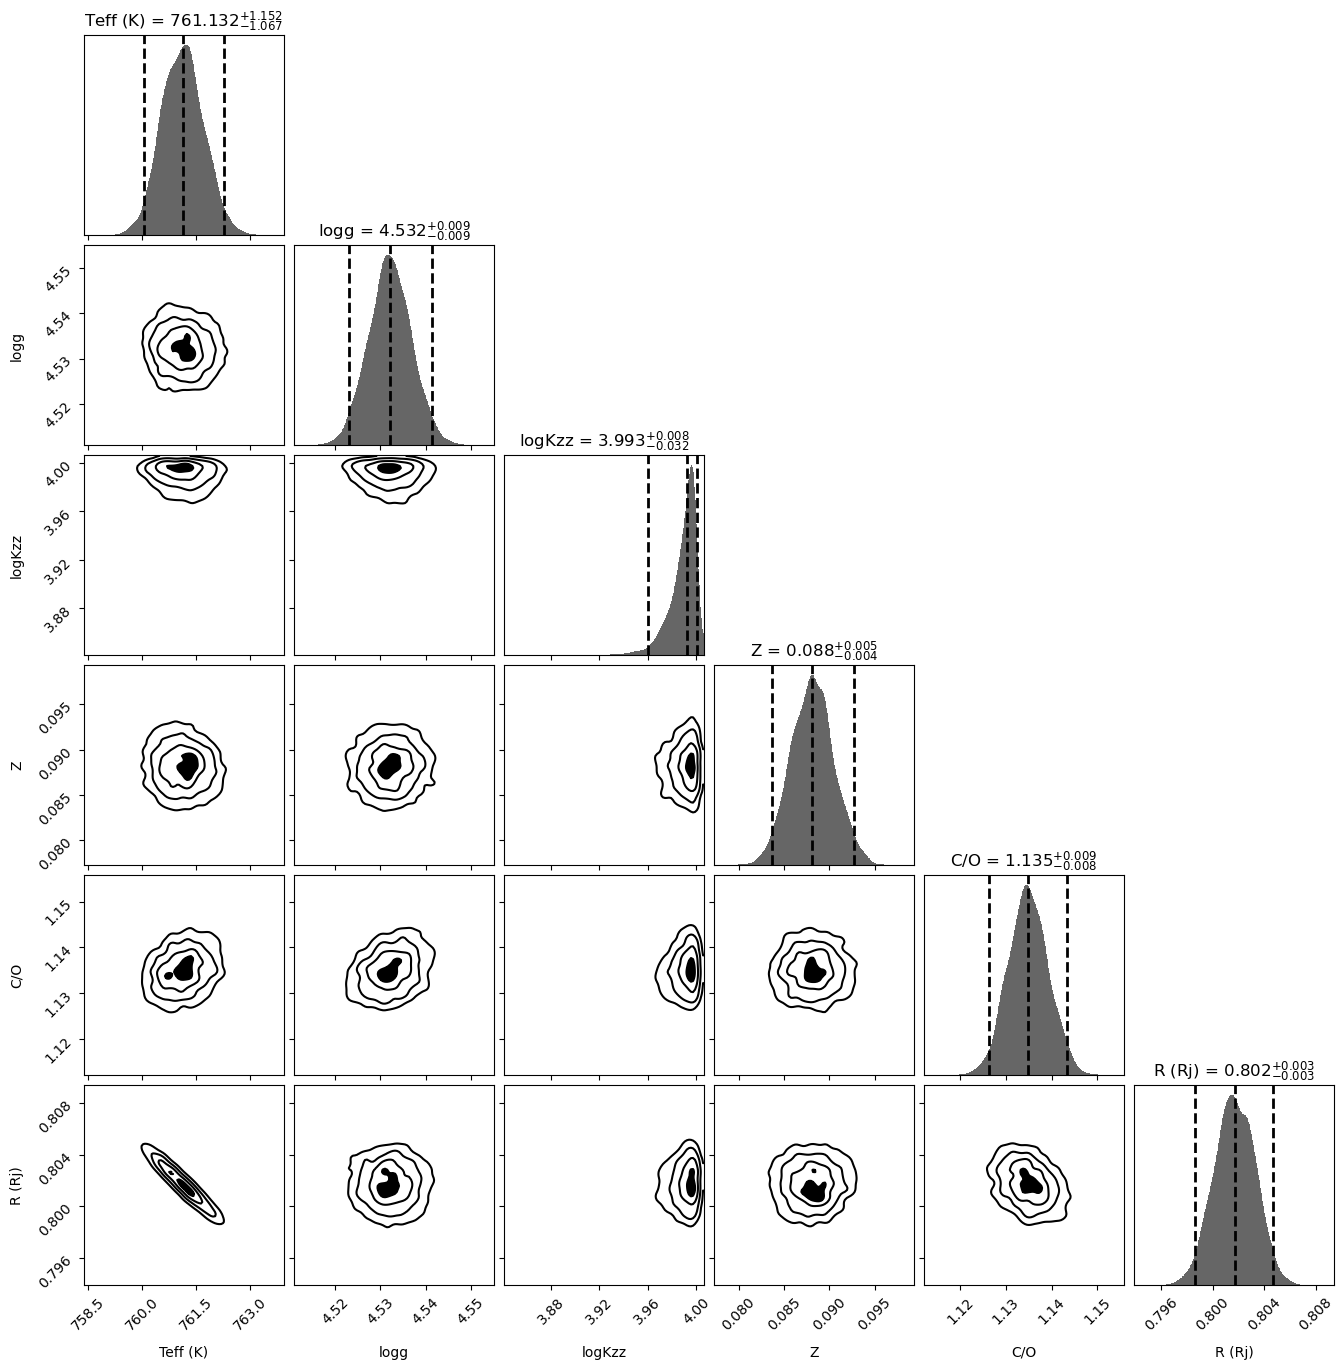

In [36]:
# Plot the 2-D marginalized posteriors.
import matplotlib.pyplot as plt

labels = ['Teff (K)', 'logg', 'logKzz', 'Z', 'C/O', 'R (Rj)']
fig, axes = dyplot.cornerplot(out_bayes, show_titles=True, verbose='true', 
                              title_fmt='.3f', #, #.1f, .2f, .1f',
                              title_kwargs={'y': 1.0}, labels=labels)

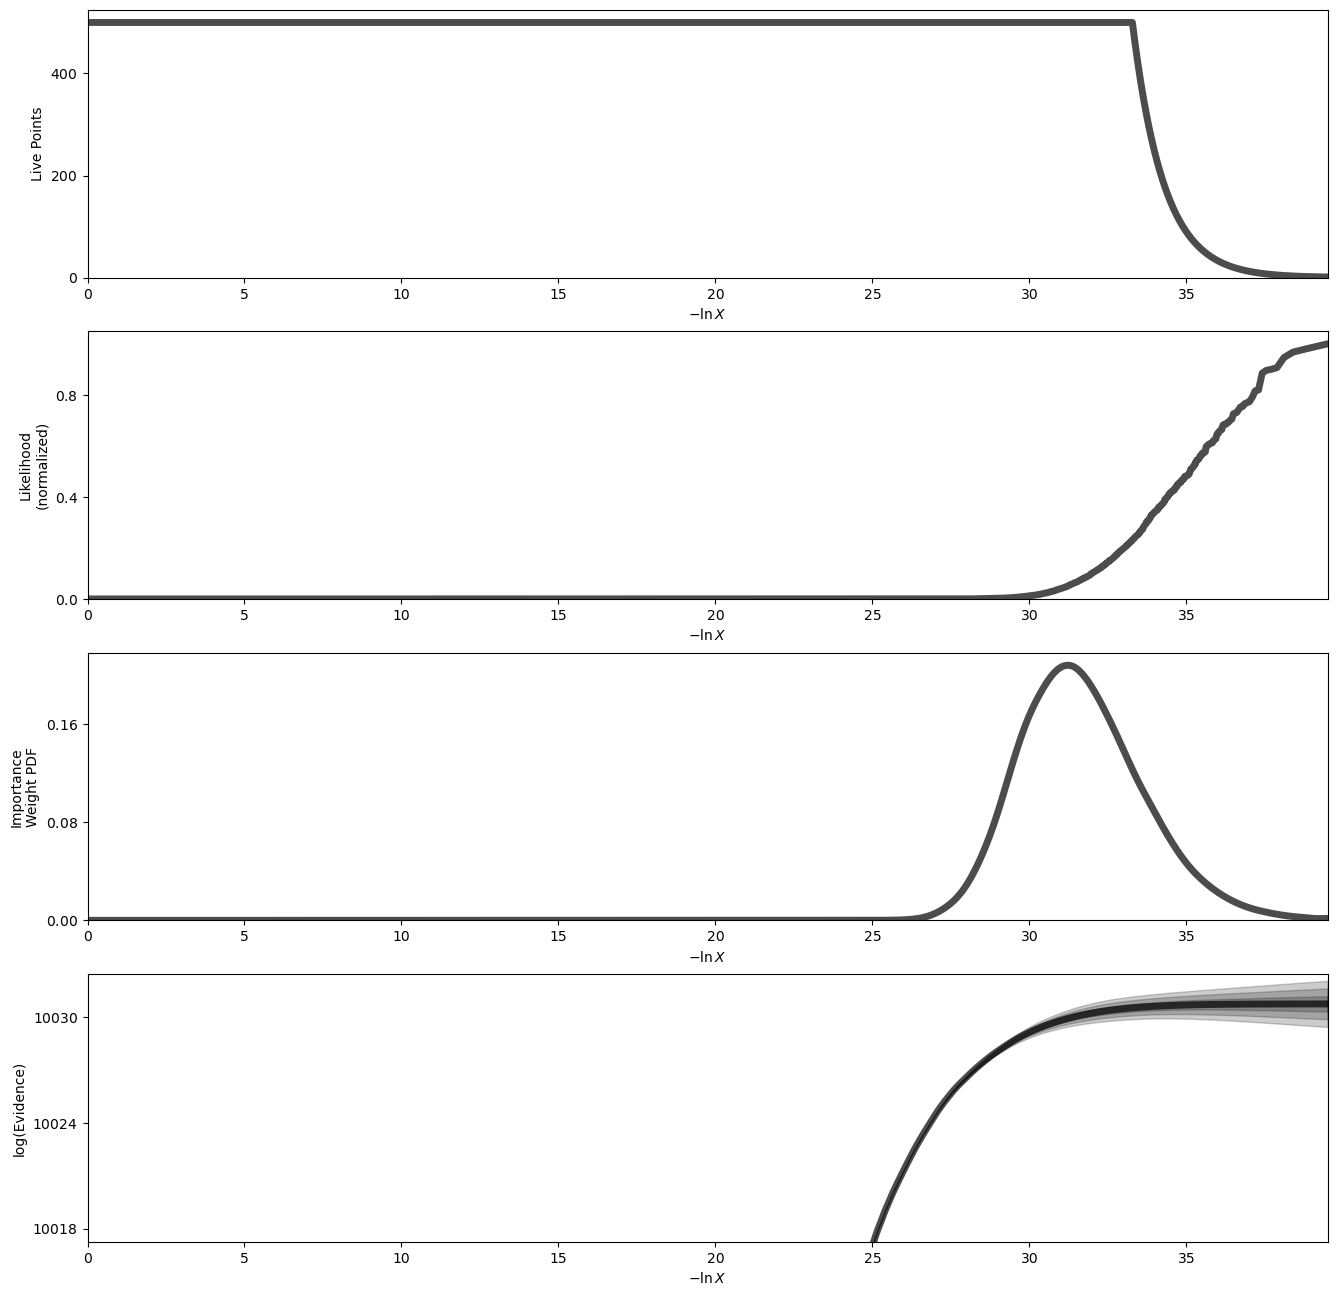

In [18]:
# Plot a summary of the run

fig, axes = dyplot.runplot(out_bayes, color='black', mark_final_live=False, logplot=True)

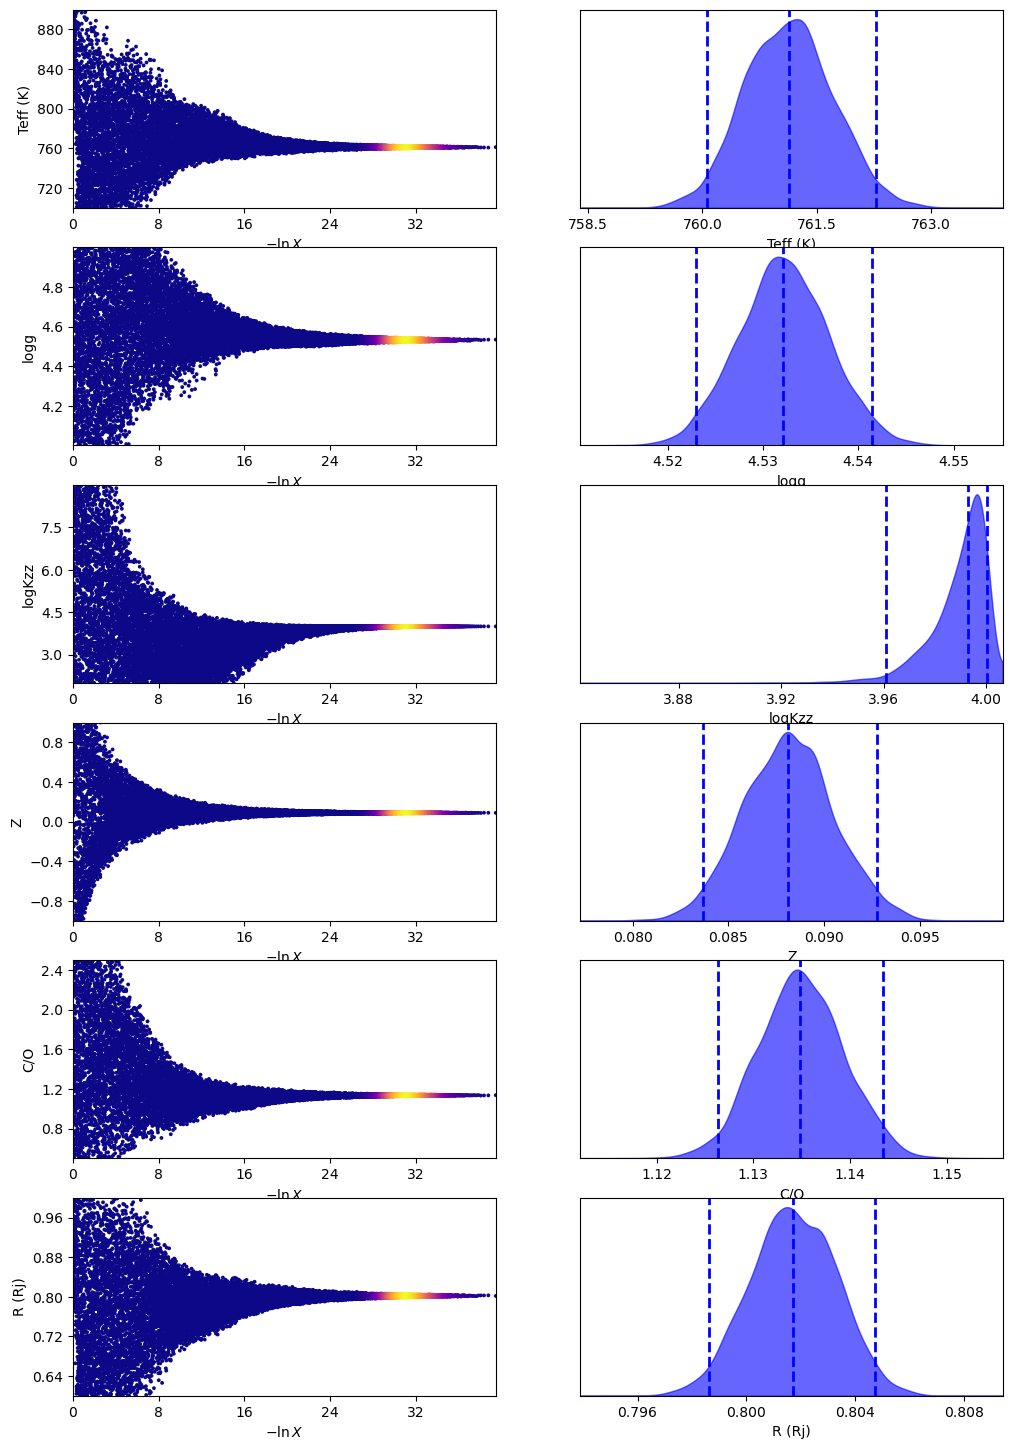

In [20]:
# Plot traces and 1-D marginalized posteriors

fig, axes = dyplot.traceplot(out_bayes, labels=labels)